In [1]:
import warnings

import numpy as np
from numpy import array
import pandas as pd
from pandas import concat
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import ParameterGrid
import seaborn as sns
from pmdarima import auto_arima

warnings.filterwarnings("ignore")

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
df_daily = pd.read_csv('salesdaily.xls', index_col = "datum")

In [3]:
df = df_daily.copy()
df_daily.drop(['R06', 'R03', 'N05B', 'N05C', 'N02BE', 'N02BA', 'M01AE'], axis = 1, inplace = True)

In [4]:
df.head()

df_daily.head()

,M01AB,Year,Month,Hour,Weekday Name
datum,,,,,
1/2/2014,0.0,2014,1,248,Thursday
1/3/2014,8.0,2014,1,276,Friday
1/4/2014,2.0,2014,1,276,Saturday
1/5/2014,4.0,2014,1,276,Sunday
1/6/2014,5.0,2014,1,276,Monday


<AxesSubplot:title={'center':'M01AB'}, xlabel='Month'>

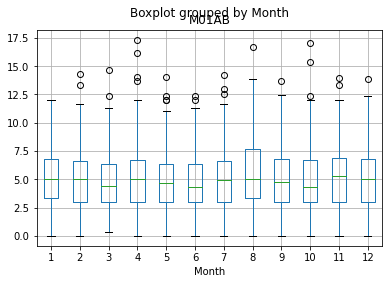

In [5]:
# Monthly 'M01AB' sales
df_daily.boxplot(column = ['M01AB'], by='Month')

<AxesSubplot:title={'center':'M01AB'}, xlabel='Weekday Name'>

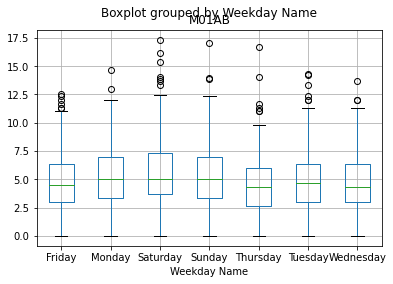

In [6]:
# Weekly 'M01AB' sales
df_daily.boxplot(column = ['M01AB'], by='Weekday Name')

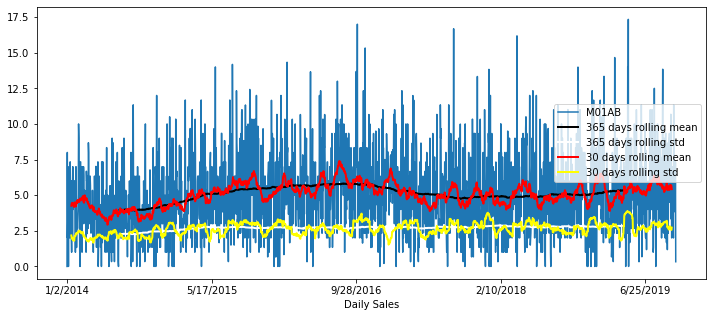

In [7]:
# Rolling Mean and Standard Deviation for monthly and yearly data

df_daily['365 days rolling mean'] = df_daily['M01AB'].rolling(window=365, center=True).mean()
df_daily['365 days rolling std'] = df_daily['M01AB'].rolling(window=365, center=True).std()

df_daily['30 days rolling mean'] = df_daily['M01AB'].rolling(30, center=True).mean()
df_daily['30 days rolling std'] = df_daily['M01AB'].rolling(30, center=True).std()

ax = df_daily['M01AB'].plot(figsize=(12,5))
ax.plot(df_daily['365 days rolling mean'], color='black', linewidth=2, label = '365 days rolling mean')
ax.plot(df_daily['365 days rolling std'], color='white', linewidth=2, label = '365 days rolling std')
ax.plot(df_daily['30 days rolling mean'], color='red', linewidth=2, label = '30 days rolling mean')
ax.plot(df_daily['30 days rolling std'], color='yellow', linewidth=2, label = '30 days rolling std')

ax.autoscale(axis='y')
ax.set(xlabel = 'Daily Sales', ylabel = '')
ax.legend(loc=5)

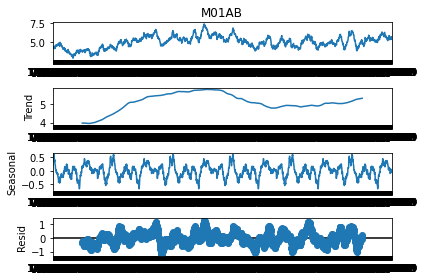

In [8]:
# Seasonal Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_daily['M01AB'].rolling(30, center=True).mean().dropna(), freq=365, filt=None)
#plt.rcParams["figure.figsize"] = (20,20)
result.plot()
plt.show()

In [9]:
df_weekly = pd.read_csv('salesweekly.xls')

result = seasonal_decompose(df_weekly['M01AB'], freq=52, model='additive')
dfs = pd.concat([result.trend, result.seasonal, result.resid, result.observed], axis=1)

dfs.columns = ['trend', 'seasonal', 'residuals', 'observed']
dfs = dfs.dropna()
    
res = dfs['residuals'].values
obs = dfs['observed'].values
    
resmean = np.mean(np.abs(res))
obsmean = np.mean(np.abs(obs))
    
perc = resmean*100/obsmean
print('M01AB RESMEAN:' + str(resmean) + ', OBSMEAN:' + str(obsmean) + ', PERC:' + str(perc) + '%')

M01AB RESMEAN:5.267159962841151, OBSMEAN:35.59490833332001, PERC:14.79750955815953%


<AxesSubplot:>

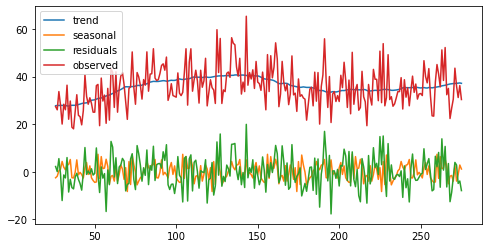

In [10]:
dfs.plot(figsize=(8,4))

In [11]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(df_weekly['M01AB'], regression='ct', autolag='AIC')

print("ADF test for M01AB")
print("-----------------------------")
print("Test statistic = {:.2f}".format(dftest[0]))
print("P-value = {:.2f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

ADF test for M01AB
-----------------------------
Test statistic = -3.70
P-value = 0.02
Critical values :
	1%: -3.9897903649837616 - The data is not stationary with 99% confidence
	5%: -3.425478311521626 - The data is  stationary with 95% confidence
	10%: -3.1358607194990724 - The data is  stationary with 90% confidence


In [12]:
dftest

(-3.699555352238167,
 0.022386551571704223,
 6,
 295,
 {'1%': -3.9897903649837616,
  '5%': -3.425478311521626,
  '10%': -3.1358607194990724},
 2000.7374492936378)

In [13]:
from statsmodels.tsa.stattools import kpss

print(" > Is M01AB data stationary ?")

dftest = kpss(np.log(df['M01AB']), 'ct')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[3].items():
    print("\t{}: {}".format(k, v))

 > Is M01AB data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


In [14]:
def ApEn(U, m, r):
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])
    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))
    N = len(U)
    return abs(_phi(m+1) - _phi(m))

print('M01AB: ' + str(ApEn(df['M01AB'].values, m=2, r=0.2*np.std(df['M01AB'].values))))

M01AB: 1.9240540330273106


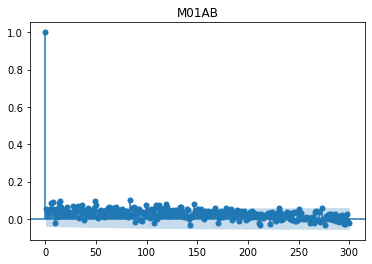

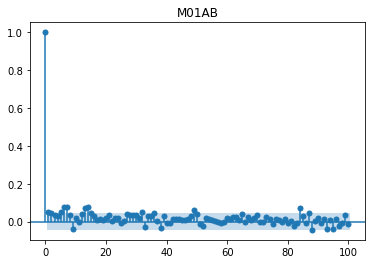

In [15]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

with plt.rc_context():
    plt.rc("figure", figsize=(6,4))
    plot_acf(df['M01AB'], lags=300, title='M01AB')
    plot_pacf(df['M01AB'], lags=100, title='M01AB')



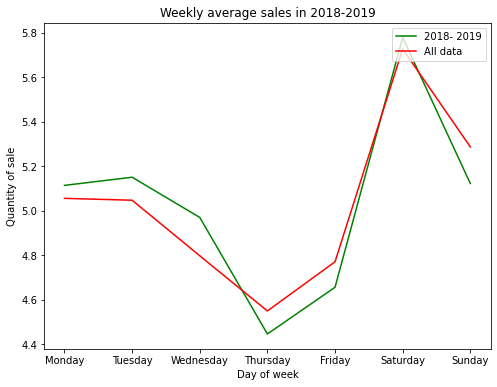

In [17]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.rcParams.update({'font.size': 10})

grp1=df_daily.loc[df_daily.index > '2018-01-01'].groupby(df_daily['Weekday Name'])['M01AB'].mean().reindex(days)
grp2=df_daily.loc[df_daily.index].groupby(df_daily['Weekday Name'])['M01AB'].mean().reindex(days)


grp1.plot(color='green', figsize=(8,6), label='2018- 2019')
grp2.plot(color='red', figsize=(8,6), label='All data')


plt.legend(loc='upper right')
plt.title('Weekly average sales in 2018-2019')
plt.xlabel('Day of week')
plt.ylabel('Quantity of sale')

plt.show()

In [18]:
resultsRolling={'M01AB':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],}
resultsRollingdf = pd.DataFrame(resultsRolling)
resultsRollingdf.index = ['Naive MSE', 'Naive MAPE', 'Seasonal Naive MSE', 'Seasonal Naive MAPE', 
                          'ARIMA MSE', 'ARIMA MAPE', 'AutoARIMA MSE', 'AutoARIMA MAPE',
                         'Prophet MSE', 'Prophet MAPE']
resultsLongterm={'M01AB':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]}
resultsLongtermdf = pd.DataFrame(resultsLongterm)
resultsLongtermdf.index = ['Average MSE', 'Average MAPE', 'ARIMA MSE', 'ARIMA MAPE', 
                           'AutoARIMA MSE', 'AutoARIMA MAPE', 'Prophet MSE', 'Prophet MAPE',
                          'Vanilla LSTM MSE', 'Vanilla LSTM MAPE', 'Stacked LSTM MSE', 'Stacked LSTM MAPE',
                          'Bidirectional LSTM MSE', 'Bidirectional LSTM MAPE']

In [19]:
import statsmodels.api as sm

for col in ['R06', 'R03', 'N05B', 'N05C', 'N02BE', 'N02BA', 'M01AE']:
    resDiff = sm.tsa.arma_order_select_ic(df_weekly[col], max_ar=5, max_ma=5, ic='aic', trend='c')
    print('ARMA(p,q,' + col + ') =',resDiff['aic_min_order'],'is the best.')


ARMA(p,q,R06) = (2, 2) is the best.
ARMA(p,q,R03) = (3, 3) is the best.
ARMA(p,q,N05B) = (5, 5) is the best.
ARMA(p,q,N05C) = (4, 5) is the best.
ARMA(p,q,N02BE) = (2, 2) is the best.
ARMA(p,q,N02BA) = (5, 4) is the best.
ARMA(p,q,M01AE) = (2, 0) is the best.


In [20]:
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    error = mean_squared_error(test, predictions)
    return error

def evaluate_models(f, dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue
    print(f+' - Best ARIMA%s MSE=%.3f (1st function)' % (best_cfg, best_score))

p_values = range(0, 6)
d_values = range(0, 2)
q_values = range(0, 6)

evaluate_models('M01AB', df_weekly['M01AB'].values, p_values, d_values, q_values)

M01AB - Best ARIMA(0, 0, 0) MSE=61.971 (1st function)


In [21]:
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) - 50)
    train, test = X[0:train_size], X[train_size:]
    model = ARIMA(train, order=arima_order)
    model_fit = model.fit()
    forecast = model_fit.predict(1,len(test))
    error = mean_squared_error(test, forecast)
    return error

def evaluate_models(f, dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue
    print(f+' - Best ARIMA%s MSE=%.3f (2nd Function)' % (best_cfg, best_score))

p_values = range(0, 6)
d_values = range(0, 2)
q_values = range(0, 6)

warnings.filterwarnings("ignore")

evaluate_models('M01AB', df_weekly['M01AB'].values, p_values, d_values, q_values)

M01AB - Best ARIMA(0, 0, 0) MSE=75.429 (2nd Function)


In [22]:
M01AB= {'series':'M01AB','p':0,'d':0,'q':0}

X = df_weekly[M01AB['series']].values
size = len(X)-50
train, test = X[0:size], X[size:len(X)]
history = [M01AB for M01AB in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(0, 0, 0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

error = mean_squared_error(test, predictions)
perror = mean_absolute_percentage_error(test, predictions)

resultsRollingdf.loc['ARIMA MSE', 'M01AB']=error
resultsRollingdf.loc['ARIMA MAPE', 'M01AB']=perror


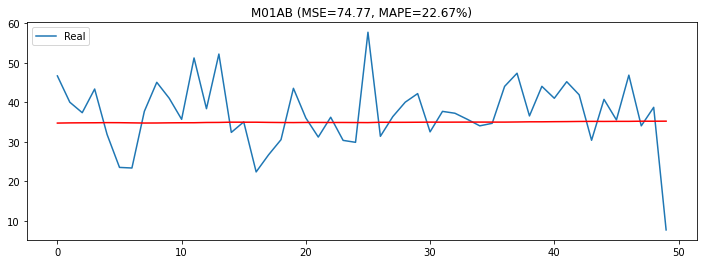

In [23]:
fig, ax = plt.subplots(nrows=1, ncols = 1, figsize = (12,4))
ax.plot(test)
ax.set_title('M01AB (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
ax.legend(['Real', 'Predicted'], loc='upper left')
ax.plot(predictions, color='red')
plt.show()

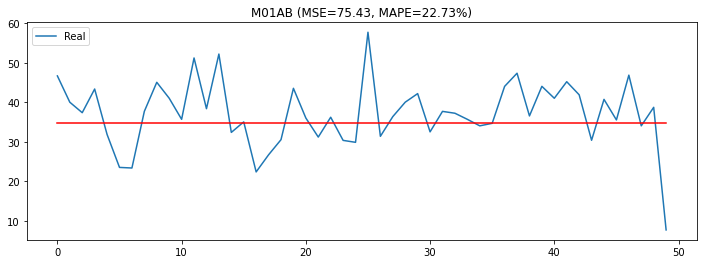

In [24]:
M01AB= {'series':'M01AB','p':0,'d':0,'q':0}

X = df_weekly['M01AB'].values
size = int(len(X) - 50)
train, test = X[0:size], X[size:len(X)]
model = ARIMA(train, order=(0,0 ,0))

model_fit = model.fit()
forecast = model_fit.predict(1,len(test))
error = mean_squared_error(test, forecast)
perror = mean_absolute_percentage_error(test, forecast)

resultsLongtermdf.loc['ARIMA MSE', 'M01AB']=error
resultsLongtermdf.loc['ARIMA MAPE', 'M01AB']=perror

fig, ax = plt.subplots(nrows=1, ncols = 1, figsize = (12,4))
ax.plot(test)
ax.set_title('M01AB (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
ax.legend(['Real', 'Predicted'], loc='upper left')
ax.plot(forecast, color='red')
plt.show()

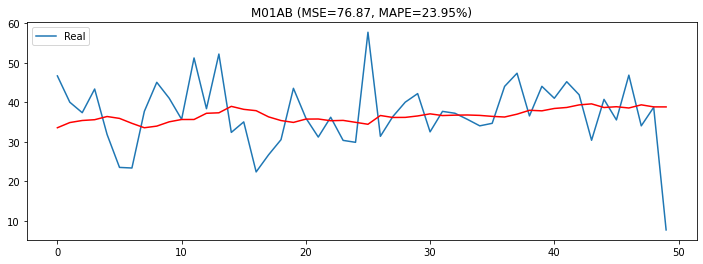

In [25]:

X = df_weekly['M01AB'].values
size = len(X)-50
    
train, test = X[0:size], X[size:len(X)]
history = [c for c in train]
predictions = list()

for t in range(len(test)):
    model = auto_arima(X, start_p=1, start_q=1,
                           max_p=5, max_q=5, max_d=1,
                           trace=False, seasonal=False,
                           error_action='ignore',
                           suppress_warnings=True, 
                           stepwise=True)
    model_fit = model.fit(history)
    output = model_fit.predict(n_periods=1)
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    
error = mean_squared_error(test, predictions)
perror = mean_absolute_percentage_error(test, predictions)
resultsRollingdf.loc['AutoARIMA MSE', 'M01AB']=error
resultsRollingdf.loc['AutoARIMA MAPE','M01AB']=perror

fig, ax = plt.subplots(nrows=1, ncols = 1, figsize = (12,4))
ax.plot(test)
ax.set_title('M01AB (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
ax.legend(['Real', 'Predicted'], loc='upper left')
ax.plot(predictions, color='red')
plt.show()

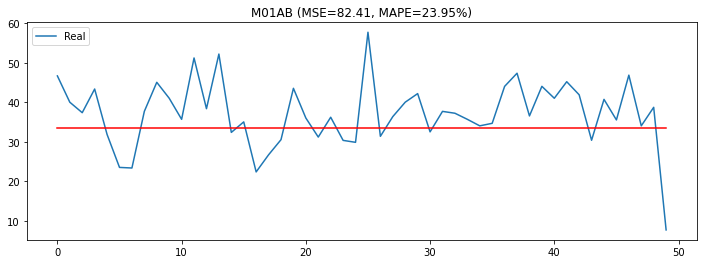

In [26]:
X = df_weekly['M01AB'].values
size = int(len(X) - 50)
train, test = X[0:size], X[size:len(X)]
model = auto_arima(X, start_p=1, start_q=1,
                           max_p=5, max_q=5, max_d=1,
                           trace=False, seasonal=False,
                           error_action='ignore',
                           suppress_warnings=True, 
                           stepwise=True)
model_fit = model.fit(train)

forecast = model_fit.predict(n_periods=len(test))
error = mean_squared_error(test, forecast)
perror = mean_absolute_percentage_error(test, predictions)
resultsLongtermdf.loc['AutoARIMA MSE', 'M01AB']=error
resultsLongtermdf.loc['AutoARIMA MAPE', 'M01AB']=perror

fig, ax = plt.subplots(nrows=1, ncols = 1, figsize = (12,4))
ax.plot(test)
ax.set_title('M01AB (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
ax.legend(['Real', 'Predicted'], loc='upper left')
ax.plot(forecast, color='red')